Temas:

Economia:
Otimização média-variância (modelo de Markowitz) e modelo de três fatores de Fama-French

Estatística:
Inferência bayesiana e modelos com agrupamento parcial

Ciência de dados:
Scraping, limpeza de dados e concatenação de tabelas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import os
import yfinance as yf
import scipy.optimize as sco
%matplotlib inline

In [2]:
risk_free = pd.read_excel('http://nefin.com.br/resources/risk_factors/Risk_Free.xls')
risk_free["Date"] = pd.to_datetime(risk_free[['year', 'month', "day"]])
risk_free.set_index("Date", inplace=True, drop=True)
risk_free = risk_free["Risk_free"]["2015-01-01":"2022-01-01"]
risk_free

Date
2015-01-02    0.000443
2015-01-05    0.000444
2015-01-06    0.000444
2015-01-07    0.000445
2015-01-08    0.000446
                ...   
2021-12-23    0.000348
2021-12-27    0.000348
2021-12-28    0.000347
2021-12-29    0.000348
2021-12-30    0.000347
Name: Risk_free, Length: 1730, dtype: float64

In [3]:
etf_data = yf.download("PIBB11.SA SMAL11.SA IVVB11.SA", start="2014-12-30", end="2022-01-01", interval="1d")["Close"].apply(np.log).diff().dropna()
etf_data = etf_data.T.sub(risk_free).T * 252
etf_data

[*********************100%***********************]  3 of 3 completed


,IVVB11.SA,PIBB11.SA,SMAL11.SA
Date,,,
2015-01-02,1.746882,-0.111566,-5.337284
2015-01-05,-0.337918,-0.112013,-7.335679
2015-01-06,-4.213377,-0.112013,-2.868874
2015-01-07,1.353815,-0.112103,6.110436
2015-01-08,2.749068,-0.112282,3.548800
...,...,...,...
2021-12-23,1.961866,-0.944656,-1.468859
2021-12-27,1.603364,1.320711,2.195154
2021-12-28,-0.541398,-2.397541,1.169287


In [4]:
market_factor = pd.read_excel('http://nefin.com.br/resources/risk_factors/Market_Factor.xls')
smb_factor = pd.read_excel('http://nefin.com.br/resources/risk_factors/SMB_Factor.xls')
hml_factor = pd.read_excel('http://nefin.com.br/resources/risk_factors/HML_Factor.xls')
market_factor["Date"] = pd.to_datetime(market_factor[['year', 'month', "day"]])
smb_factor["Date"] = pd.to_datetime(smb_factor[['year', 'month', "day"]])
hml_factor["Date"] = pd.to_datetime(hml_factor[['year', 'month', "day"]])
market_factor.set_index("Date", inplace=True, drop=True)
smb_factor.set_index("Date", inplace=True, drop=True)
hml_factor.set_index("Date", inplace=True, drop=True)
market_factor = market_factor["Rm_minus_Rf"]
smb_factor = smb_factor["SMB"]
hml_factor = hml_factor["HML"]

In [5]:
dataset = pd.concat([etf_data, market_factor, smb_factor, hml_factor], axis=1).dropna()
backtest_data = dataset[["IVVB11.SA", "PIBB11.SA", "SMAL11.SA"]]["2021-01-01":"2022-01-01"]
assets = dataset[["IVVB11.SA", "PIBB11.SA", "SMAL11.SA"]]["2015-01-01":"2021-01-01"]

In [6]:
dataset

,IVVB11.SA,PIBB11.SA,SMAL11.SA,Rm_minus_Rf,SMB,HML
Date,,,,,,
2015-01-02,1.746882,-0.111566,-5.337284,-0.028348,0.008808,-0.001127
2015-01-05,-0.337918,-0.112013,-7.335679,-0.020330,-0.018993,-0.003513
2015-01-06,-4.213377,-0.112013,-2.868874,0.008800,-0.025032,0.010526
2015-01-07,1.353815,-0.112103,6.110436,0.026667,-0.007551,0.011214
2015-01-08,2.749068,-0.112282,3.548800,0.007735,-0.004702,-0.001282
...,...,...,...,...,...,...
2021-12-23,1.961866,-0.944656,-1.468859,-0.002221,0.000421,0.002337
2021-12-27,1.603364,1.320711,2.195154,0.005992,0.006823,-0.002394
2021-12-28,-0.541398,-2.397541,1.169287,-0.004244,0.012719,0.008525


Otimização média-variância é feita em 2 passos:

1) Estimação do retorno médio de cada ativo e matriz de covariância

2) Otimização da carteira para encontrar alocação (pesos)

Existem várias abordagens possíveis para o primeiro passo

O modelo clássico de Markowitz usa os retornos médios e matriz de covariância amostrais

In [7]:
sample_mean_ret = assets.mean()
sample_mean_ret

IVVB11.SA    0.143729
PIBB11.SA    0.073558
SMAL11.SA    0.076093
dtype: float64

In [8]:
sample_cov_matrix = assets.cov()
sample_cov_matrix

,IVVB11.SA,PIBB11.SA,SMAL11.SA
IVVB11.SA,31.700288,3.428053,3.044658
PIBB11.SA,3.428053,28.557407,10.735005
SMAL11.SA,3.044658,10.735005,20.241200


In [9]:
sample_stds = assets.std()
sample_stds

IVVB11.SA    5.630301
PIBB11.SA    5.343913
SMAL11.SA    4.499022
dtype: float64

In [10]:
sample_corr = assets.corr()
sample_corr

,IVVB11.SA,PIBB11.SA,SMAL11.SA
IVVB11.SA,1.000000,0.113935,0.120196
PIBB11.SA,0.113935,1.000000,0.446503
SMAL11.SA,0.120196,0.446503,1.000000


Na inferência bayesiana, podemos obter resultados similares aos da inferência clássica (frequentista) colocando prioris difusas nos parâmetros

Para cada ativo $i$, teremos:

$\sigma^2 \sim IG(\alpha=0.0001,\beta=0.0001)$ 

$\rho_{i,j} \sim Uniform(-1,1), i \neq j$

$\mu \sim Uniform(-\infty,\infty)$

$y | \mu_i,\sigma^2 \sim N(\mu,\Sigma)$

In [11]:
with pm.Model() as model_classic:
    sd_0 = pm.HalfCauchy.dist(beta=1)
    mu = pm.Flat('mu', shape = 3)
    chol, corr, sd = pm.LKJCholeskyCov('chol_cov', n=3, eta=1, sd_dist=sd_0, compute_corr=True)

    cov = pm.Deterministic("cov", chol.dot(chol.T))
    
    likelihood = pm.MvNormal('y', mu=mu, chol=chol, observed=assets.values)

In [12]:
with model_classic:
    trace_classic = pm.sample(5000, tune=2000, target_accept=0.8, init='adapt_diag')

/home/thomas/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [chol_cov, mu]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 60 seconds.


In [13]:
az.summary(trace_classic)

/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],0.143,0.148,-0.119,0.437,0.001,0.001,11489.0,8469.0,11490.0,8007.0,1.0
mu[1],0.077,0.138,-0.170,0.348,0.002,0.001,8150.0,6907.0,8148.0,7614.0,1.0
mu[2],0.078,0.117,-0.154,0.284,0.001,0.001,9418.0,7561.0,9428.0,8600.0,1.0
chol_cov[0],5.635,0.104,5.441,5.827,0.001,0.001,12905.0,12894.0,12920.0,8132.0,1.0
chol_cov[1],0.607,0.139,0.342,0.867,0.001,0.001,10632.0,10467.0,10627.0,8335.0,1.0
chol_cov[2],5.310,0.097,5.132,5.499,0.001,0.001,10814.0,10787.0,10851.0,8485.0,1.0
chol_cov[3],0.537,0.116,0.329,0.765,0.001,0.001,10479.0,10197.0,10481.0,8672.0,1.0
chol_cov[4],1.954,0.111,1.751,2.162,0.001,0.001,12601.0,12586.0,12582.0,8394.0,1.0
chol_cov[5],4.015,0.073,3.876,4.152,0.001,0.000,12076.0,12074.0,12068.0,8438.0,1.0
chol_cov_stds[0],5.635,0.104,5.441,5.827,0.001,0.001,12905.0,12894.0,12920.0,8132.0,1.0


/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'chol_cov'}>,
        <AxesSubplot:title={'center':'chol_cov'}>],
       [<AxesSubplot:title={'center':'chol_cov_stds'}>,
        <AxesSubplot:title={'center':'chol_cov_stds'}>],
       [<AxesSubplot:title={'center':'chol_cov_corr'}>,
        <AxesSubplot:title={'center':'chol_cov_corr'}>],
       [<AxesSubplot:title={'center':'cov'}>,
        <AxesSubplot:title={'center':'cov'}>]], dtype=object)

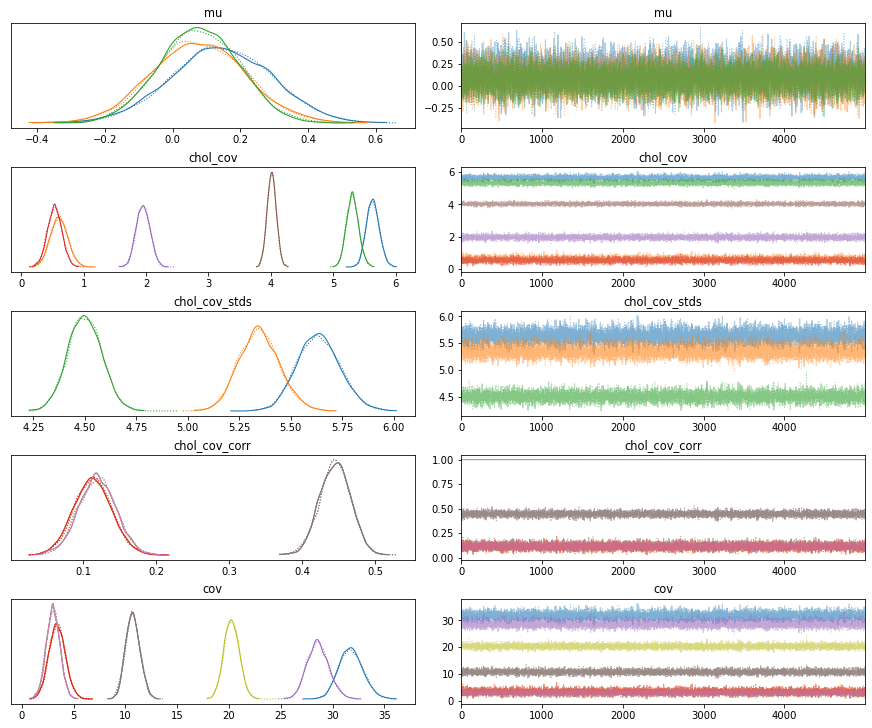

In [14]:
az.plot_trace(trace_classic)

Vemos que as médias das posterioris se aproximam das médias, desvios padrões e correlações amostrais.

A primeira técnica bayesiana para estimação dos retornos médios que iremos utilizar é o estimador de James-Stein (J-S)

O estimador J-S para o vetor de média de uma distribuição normal multivariada (nosso caso) faz uso das chamadas "shrinkage priors": distribuições a priori que "puxam" as distribuições a posteriori estimadas para um determinado valor. Na nossa aplicação, podemos "puxar" a estimativa a posteriori dos retornos médios para o zero, refletindo um certo ceticismo a respeito de valores extremos (muito grandes ou muito pequenos) observados para os retornos. 

É possível demonstrar matematicamente que o estimador J-S sempre terá um EQM menor ou igual que os estimadores de máxima verossimilhança (os retornos médios e covariâncias amostrais) para uma normal multivariada de dimensão maior ou igual a 3

Usaremos uma especificação "empirical Bayes": o vetor de retornos médios terá distribuição normal multivariada com média 0 e matriz de covariância igual à matriz de covariância amostral $S$

$\sigma^2 \sim IG(\alpha=0.0001,\beta=0.0001)$ 

$\rho_{i,j} \sim U(-1,1), i \neq j$

$\mu \sim N(0,S)$
            
$y|\mu,\sigma^2 \sim N(\mu,\Sigma)$

In [15]:
with pm.Model() as model_JS:
    sd_0 = pm.InverseGamma.dist(alpha=0.0001,beta=0.0001)
    mu = pm.MvNormal('mu', mu=np.zeros(3), cov=sample_cov_matrix, shape = 3)
    chol, corr, sd = pm.LKJCholeskyCov('chol_cov', n=3, eta=1, sd_dist=sd_0, compute_corr=True)
    
    cov = pm.Deterministic("cov", chol.dot(chol.T))
    
    likelihood = pm.MvNormal('y', mu=mu, chol=chol, observed=assets.values)
# pm.model_to_graphviz(model_JS)

In [16]:
with model_JS:
    trace_JS = pm.sample(2000, tune=1000, target_accept=0.8, init='advi+adapt_diag')

/home/thomas/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 14700
Interrupted at 14,699 [7%]: Average Loss = 43,691
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [chol_cov, mu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 23 seconds.


In [17]:
az.summary(trace_JS)

/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],0.142,0.147,-0.125,0.421,0.002,0.002,4706.0,3606.0,4693.0,3088.0,1.0
mu[1],0.071,0.135,-0.170,0.336,0.002,0.002,3548.0,3037.0,3558.0,3382.0,1.0
mu[2],0.074,0.115,-0.139,0.292,0.002,0.002,3956.0,2917.0,3973.0,3414.0,1.0
chol_cov[0],5.635,0.105,5.435,5.825,0.002,0.001,4326.0,4306.0,4378.0,2799.0,1.0
chol_cov[1],0.609,0.138,0.359,0.872,0.002,0.002,3657.0,3609.0,3661.0,3184.0,1.0
chol_cov[2],5.312,0.099,5.131,5.502,0.001,0.001,4906.0,4901.0,4899.0,3435.0,1.0
chol_cov[3],0.541,0.116,0.326,0.763,0.002,0.001,3974.0,3971.0,3977.0,3636.0,1.0
chol_cov[4],1.956,0.111,1.740,2.148,0.002,0.001,4416.0,4416.0,4410.0,3139.0,1.0
chol_cov[5],4.017,0.074,3.879,4.161,0.001,0.001,5196.0,5196.0,5150.0,3212.0,1.0
chol_cov_stds[0],5.635,0.105,5.435,5.825,0.002,0.001,4326.0,4306.0,4378.0,2799.0,1.0


/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'chol_cov'}>,
        <AxesSubplot:title={'center':'chol_cov'}>],
       [<AxesSubplot:title={'center':'chol_cov_stds'}>,
        <AxesSubplot:title={'center':'chol_cov_stds'}>],
       [<AxesSubplot:title={'center':'chol_cov_corr'}>,
        <AxesSubplot:title={'center':'chol_cov_corr'}>],
       [<AxesSubplot:title={'center':'cov'}>,
        <AxesSubplot:title={'center':'cov'}>]], dtype=object)

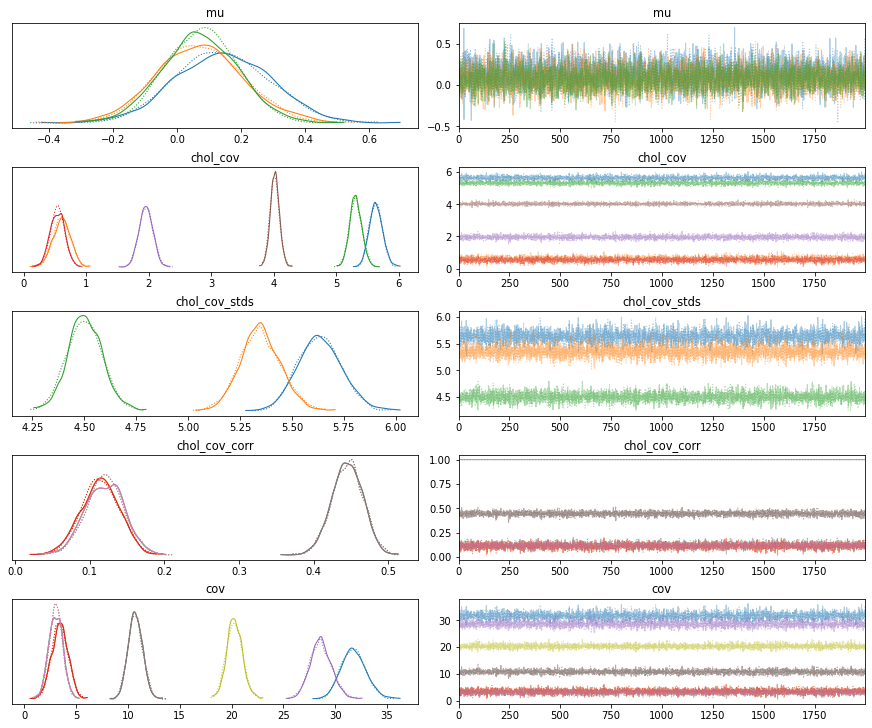

In [18]:
az.plot_trace(trace_JS)

𝜇𝜇A próxima técnica de estimação bayesiana é o agrupamento parcial (partial pooling), ou modelagem hierárquica.

https://widdowquinn.github.io/Teaching-Stan-Hierarchical-Modelling/07-partial_pooling_intro.html

Sempre que temos em nossos dados várias observações para grupos diferentes, no nosso caso os ativos, temos três possibilidades de modelagem.

A primeira é o agrupamento total: tratamos as amostras de todos os grupos como oriundas da mesma distribuição. Isto não permite nenhuma variação além da variação amostral. No nosso caso, os retornos de cada um dos ativos viriam da mesma distribuição, com mesma média e variância.

A segunda é o não-agrupamento: teremos distribuições a priori completamente separadas para os parâmetros (retornos médios) de cada um dos grupos (ativos). Neste caso está implícita a premissa de que as distribuições (o retorno médio) de um grupo (ativo) são completamente independentes das distribuições (retornos médios) dos outros.

Por último temos o agrupamento parcial: supomos que as amostras observadas de cada grupo (ativo) vêm de distribuições com médias diferentes, e, por meio de prioris hierárquicas, supomos que essas médias são "amostras" de uma mesma distribuição. Isto permite conceder independência aos parâmetros (retornos médios) estimados e ao mesmo tempo incluir na estimação de um parâmetro a informação contida no restante da amostra, nos outros grupos.

$\theta \sim N(0, 1)$

$\sigma_{\mu} \sim IG(\alpha=0.0001,\beta=0.0001)$

$\mu_i \sim N(\theta, \sigma_\mu)$

$P \sim LKJCorr(1)$

$\sigma_i \sim IG(\alpha=0.0001,\beta=0.0001)$

$\Sigma \sim \begin{pmatrix} \sigma_1 & 0 & 0 \\ 0 & \sigma_2 & 0 \\ 0 & 0 & \sigma_3 \end{pmatrix} P \begin{pmatrix} \sigma_1 & 0 & 0 \\ 0 & \sigma_2 & 0 \\ 0 & 0 & \sigma_3 \end{pmatrix}$


$y|\mu,\sigma \sim N(\mu_i,\Sigma)$

In [19]:
with pm.Model() as model_HB:
#     sd_0 = pm.InverseGamma.dist(alpha=0.0001,beta=0.0001)
    sd_0 = pm.HalfCauchy.dist(beta=1)
    chol, corr, sd = pm.LKJCholeskyCov('chol_cov', n=3, eta=1, sd_dist=sd_0, compute_corr=True)
    
    theta = pm.Normal("theta", mu=0, sd = 10)
    
#     sd_mu = pm.InverseGamma("sd_mu",alpha=0.0001,beta=0.0001)
    sd_mu = pm.HalfCauchy("sd_mu", beta=1)
    
    cov = pm.Deterministic("cov", chol.dot(chol.T))
    
    mu = pm.Normal("mu", mu=theta, sd = sd_mu, shape = 3)
    likelihood = pm.MvNormal('y', mu=mu, chol=chol, observed=assets.values)
# pm.model_to_graphviz(model_HB)

In [20]:
with model_HB:
    trace_HB = pm.sample(5000, tune=2000, target_accept=0.95, init='advi+adapt_diag')

/home/thomas/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 21400
Interrupted at 21,399 [10%]: Average Loss = 32,623
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_mu, theta, chol_cov]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 211 seconds.
There were 563 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8404809215493045, but should be close to 0.95. Try to increase the number of tuning steps.
There were 294 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9058665158941654, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [21]:
az.summary(trace_HB)

/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.092,0.200,-0.260,0.410,0.004,0.003,2157.0,2108.0,1593.0,2874.0,1.01
mu[0],0.111,0.120,-0.091,0.359,0.006,0.004,363.0,363.0,340.0,5581.0,1.01
mu[1],0.081,0.117,-0.135,0.309,0.003,0.002,1450.0,1450.0,1333.0,4820.0,1.01
mu[2],0.083,0.105,-0.109,0.282,0.004,0.003,703.0,703.0,714.0,4591.0,1.01
chol_cov[0],5.646,0.105,5.454,5.837,0.007,0.005,211.0,208.0,213.0,1144.0,1.01
chol_cov[1],0.621,0.140,0.359,0.868,0.009,0.006,255.0,234.0,264.0,3183.0,1.01
chol_cov[2],5.315,0.098,5.125,5.484,0.005,0.004,364.0,363.0,371.0,4146.0,1.01
chol_cov[3],0.556,0.121,0.344,0.772,0.012,0.009,107.0,88.0,112.0,179.0,1.02
chol_cov[4],1.965,0.115,1.760,2.174,0.009,0.007,155.0,147.0,160.0,703.0,1.01
chol_cov[5],4.012,0.072,3.876,4.147,0.003,0.002,666.0,663.0,711.0,5679.0,1.01


/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth

array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'chol_cov'}>,
        <AxesSubplot:title={'center':'chol_cov'}>],
       [<AxesSubplot:title={'center':'chol_cov_stds'}>,
        <AxesSubplot:title={'center':'chol_cov_stds'}>],
       [<AxesSubplot:title={'center':'chol_cov_corr'}>,
        <AxesSubplot:title={'center':'chol_cov_corr'}>],
       [<AxesSubplot:title={'center':'sd_mu'}>,
        <AxesSubplot:title={'center':'sd_mu'}>],
       [<AxesSubplot:title={'center':'cov'}>,
        <AxesSubplot:title={'center':'cov'}>]], dtype=object)

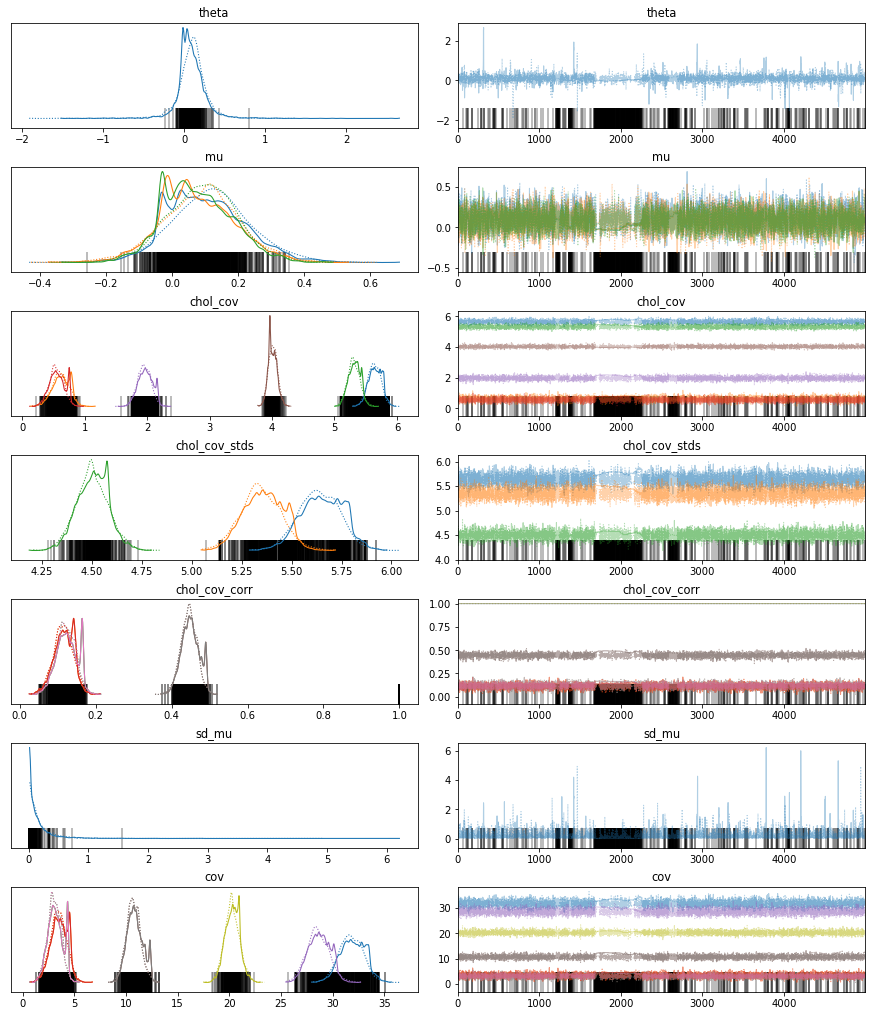

In [22]:
az.plot_trace(trace_HB)

Outra possibilidade é a de utilizar preditores na estimação do retorno esperado

Talvez o modelo mais conhecido seja o CAPM, que escreve o retorno esperado de cada ativo como função linear do retorno de mercado livre de risco:

$\mu_i = \alpha_i + \beta_i R_m + \varepsilon_i$

Já estamos desde o princípio trabalhando com retornos livres de risco, assim que não será necessário nenhuma modificação adicional neste sentido

In [23]:
market_factor = dataset["Rm_minus_Rf"]["2015-01-01":"2021-01-01"].values
market_factor = market_factor.reshape((len(market_factor),1))

In [24]:
with pm.Model() as model_CAPM:
    
    alpha_capm = pm.Normal("alpha", mu = 0, sd = 1, shape = (1,3))
    beta_capm = pm.Normal("beta", mu = 0, sd = 1, shape = (1,3))    
    
    sd_0 = pm.InverseGamma.dist(alpha=0.0001,beta=0.0001)
    chol, corr, sd = pm.LKJCholeskyCov('chol_cov', n=3, eta=1, sd_dist=sd_0, compute_corr=True)
    
    mu = alpha_capm + beta_capm * market_factor
    
    cov = pm.Deterministic("cov", chol.dot(chol.T))
    
    likelihood = pm.MvNormal('y', mu = mu, chol=chol, observed=assets.values, shape=(len(assets),3))
# pm.model_to_graphviz(model_CAPM)

In [25]:
with model_CAPM:
    trace_CAPM = pm.sample(2000, tune=1000, target_accept=0.8, init='advi+adapt_diag')

/home/thomas/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 21300
Interrupted at 21,299 [10%]: Average Loss = 34,250
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [chol_cov, beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 22 seconds.


In [26]:
az.summary(trace_CAPM)

/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"alpha[0,0]",0.140,0.144,-0.125,0.415,0.002,0.002,4166.0,3650.0,4156.0,2862.0,1.0
"alpha[0,1]",0.070,0.135,-0.186,0.325,0.002,0.002,3673.0,2900.0,3669.0,3145.0,1.0
"alpha[0,2]",0.072,0.114,-0.126,0.300,0.002,0.002,3705.0,2579.0,3717.0,2709.0,1.0
"beta[0,0]",0.078,0.980,-1.708,2.008,0.013,0.016,5450.0,1854.0,5442.0,2812.0,1.0
"beta[0,1]",0.471,0.998,-1.466,2.243,0.015,0.015,4594.0,2138.0,4605.0,3123.0,1.0
"beta[0,2]",4.414,0.996,2.585,6.285,0.014,0.010,5341.0,5229.0,5349.0,3567.0,1.0
chol_cov[0],5.635,0.101,5.443,5.827,0.001,0.001,4880.0,4880.0,4868.0,3212.0,1.0
chol_cov[1],0.605,0.138,0.343,0.861,0.002,0.001,4401.0,4278.0,4416.0,3392.0,1.0
chol_cov[2],5.307,0.096,5.129,5.495,0.001,0.001,4165.0,4165.0,4160.0,3383.0,1.0
chol_cov[3],0.528,0.114,0.319,0.737,0.002,0.001,3794.0,3757.0,3796.0,3312.0,1.0


/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'chol_cov'}>,
        <AxesSubplot:title={'center':'chol_cov'}>],
       [<AxesSubplot:title={'center':'chol_cov_stds'}>,
        <AxesSubplot:title={'center':'chol_cov_stds'}>],
       [<AxesSubplot:title={'center':'chol_cov_corr'}>,
        <AxesSubplot:title={'center':'chol_cov_corr'}>],
       [<AxesSubplot:title={'center':'cov'}>,
        <AxesSubplot:title={'center':'cov'}>]], dtype=object)

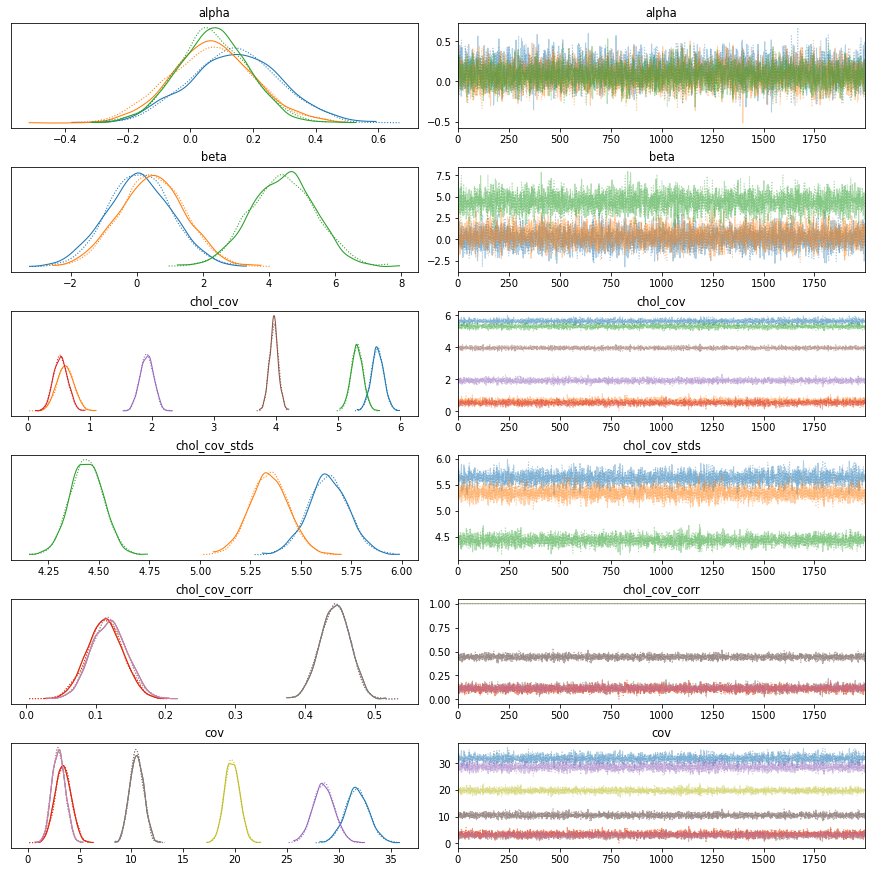

In [27]:
az.plot_trace(trace_CAPM)

Repare que obtemos um alfa muito grande para o IVVB11, dado que este replica o S&P 500 e portanto está pouco correlacionado com o mercado brasileiro

Podemos estender o exemplo para o modelo de três fatores de Fama-French, que inclui, além do fator de mercado, o SMB (prêmio de risco por investir em small caps) e o HML (prêmio de risco por investir em empresas de alto valor contábil relativo ao de mercado)

$\mu_i = \alpha_i + \beta_{Rm,i} R_{m,i} + \beta_{SMB,i} SMB_i + \beta_{HML,i} HML_i + \varepsilon_i$

In [28]:
smb_factor = dataset["SMB"]["2015-01-01":"2021-01-01"].values
smb_factor = smb_factor.reshape((len(smb_factor),1))
hml_factor = dataset["HML"]["2015-01-01":"2021-01-01"].values
hml_factor = hml_factor.reshape((len(hml_factor),1))

In [29]:
with pm.Model() as model_FF:
    
    alpha_FF = pm.Normal("alpha", mu = 0, sd = 1, shape = (1,3))
    beta_market = pm.Normal("beta_market", mu = 0, sd = 1, shape = (1,3))    
    beta_smb = pm.Normal("beta_smb", mu = 0, sd = 1, shape = (1,3)) 
    beta_hml = pm.Normal("beta_hml", mu = 0, sd = 1, shape = (1,3)) 
    
    sd_0 = pm.InverseGamma.dist(alpha=0.0001,beta=0.0001)
    chol, corr, sd = pm.LKJCholeskyCov('chol_cov', n=3, eta=1, sd_dist=sd_0, compute_corr=True)
    
    mu = alpha_FF + beta_market * market_factor + beta_smb * smb_factor + beta_hml * hml_factor
    
    cov = pm.Deterministic("cov", chol.dot(chol.T))
    
    likelihood = pm.MvNormal('y', mu = mu, chol=chol, observed=assets.values, shape=(len(assets),3))
# pm.model_to_graphviz(model_FF)

In [30]:
with model_FF:
    trace_FF = pm.sample(2000, tune=1000, target_accept=0.8, init='advi+adapt_diag')

/home/thomas/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 22000
Interrupted at 21,999 [10%]: Average Loss = 35,997
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [chol_cov, beta_hml, beta_smb, beta_market, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 28 seconds.


In [31]:
az.summary(trace_FF)

/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"alpha[0,0]",0.136,0.141,-0.138,0.395,0.002,0.002,6038.0,3127.0,6066.0,2423.0,1.0
"alpha[0,1]",0.073,0.136,-0.197,0.316,0.002,0.002,6190.0,2782.0,6171.0,3316.0,1.0
"alpha[0,2]",0.072,0.112,-0.153,0.268,0.001,0.001,5716.0,3101.0,5742.0,3218.0,1.0
"beta_market[0,0]",0.066,0.986,-1.863,1.910,0.013,0.017,6109.0,1713.0,6147.0,3009.0,1.0
"beta_market[0,1]",0.475,0.977,-1.279,2.415,0.013,0.014,5416.0,2479.0,5406.0,2813.0,1.0
"beta_market[0,2]",4.427,1.004,2.510,6.253,0.012,0.009,6984.0,6484.0,6973.0,3065.0,1.0
"beta_smb[0,0]",-0.105,1.000,-1.986,1.738,0.013,0.017,5847.0,1650.0,5840.0,2806.0,1.0
"beta_smb[0,1]",-0.180,1.015,-2.079,1.792,0.013,0.017,6004.0,1722.0,6024.0,2729.0,1.0
"beta_smb[0,2]",0.768,1.018,-1.037,2.768,0.013,0.013,6132.0,2934.0,6186.0,2847.0,1.0
"beta_hml[0,0]",-0.065,0.996,-1.849,1.837,0.012,0.017,6622.0,1818.0,6650.0,3175.0,1.0


/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/home/thomas/anaconda3/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta_market'}>,
        <AxesSubplot:title={'center':'beta_market'}>],
       [<AxesSubplot:title={'center':'beta_smb'}>,
        <AxesSubplot:title={'center':'beta_smb'}>],
       [<AxesSubplot:title={'center':'beta_hml'}>,
        <AxesSubplot:title={'center':'beta_hml'}>],
       [<AxesSubplot:title={'center':'chol_cov'}>,
        <AxesSubplot:title={'center':'chol_cov'}>],
       [<AxesSubplot:title={'center':'chol_cov_stds'}>,
        <AxesSubplot:title={'center':'chol_cov_stds'}>],
       [<AxesSubplot:title={'center':'chol_cov_corr'}>,
        <AxesSubplot:title={'center':'chol_cov_corr'}>],
       [<AxesSubplot:title={'center':'cov'}>,
        <AxesSubplot:title={'center':'cov'}>]], dtype=object)

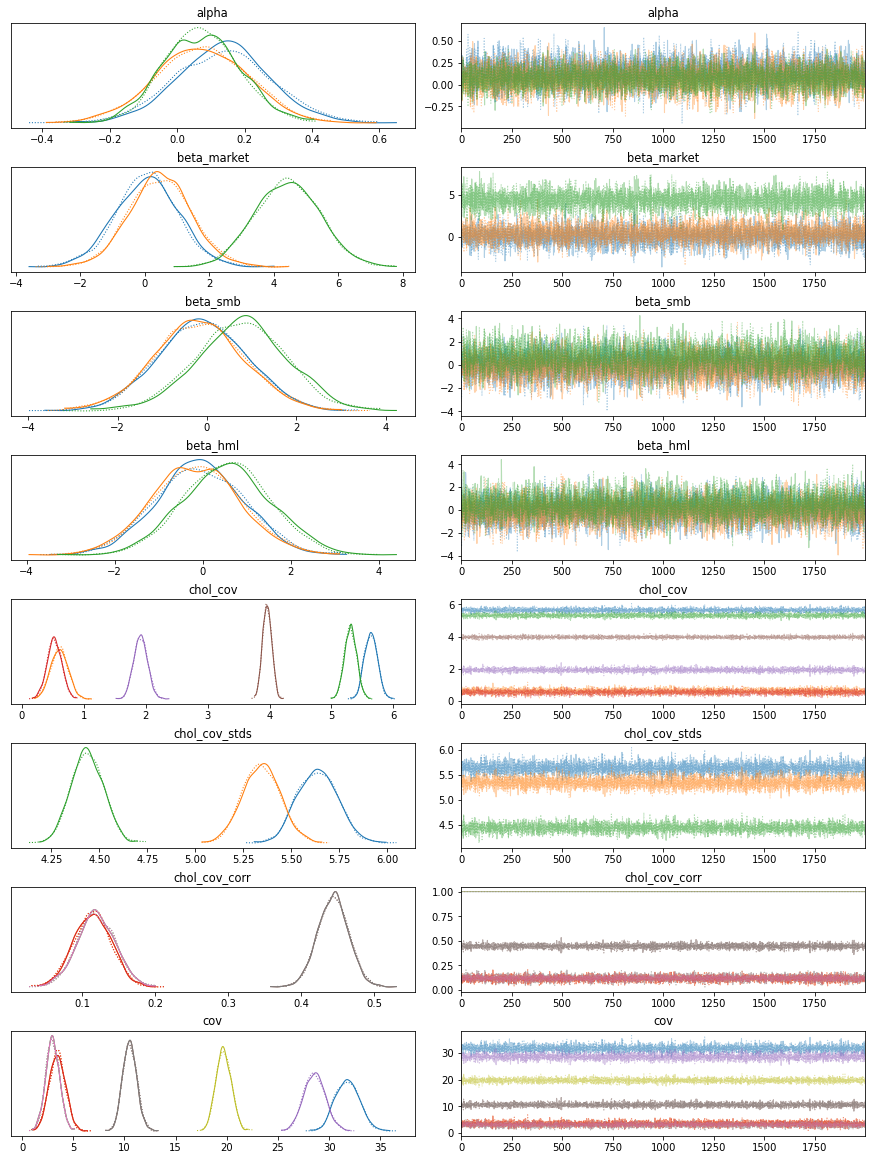

In [32]:
az.plot_trace(trace_FF)

Agora, tendo em mãos diversas estimativas dos retornos, podemos partir para a otimização

A etapa da otimização consiste em, tendo em mãos as estimativas para o retorno médio esperado e a volatilidade, encontrar os pesos para a alocação ótima da carteira seguindo algum critério

O modelo de Markowitz, também chamado de modelo de média-variância, recebe este nome como reflexo do principal trade-off em finanças: a relação entre retorno (média) e risco (volatilidade) da carteira

Logo, podemos, para um dado nível de risco, achar a alocação de maior retorno. Alternativamente, podemos fixar um nivel de retorno desejado, e encontrar a carteira de menor risco.

Nosso primeiro critério será a alocação ótima de menor variância: para o menor risco, encontrar a alocação de maior retorno

Iremos pegar a mediana da posteriori dos retornos e das covariâncias como estimativa. No entanto, como a inferência bayesiana nos dá toda a distribuição a posteriori dos parâmetros, outras medidas poderiam ter sido escolhidas

In [33]:
ret_cl = np.median(trace_classic["mu"], axis=0)
cov_cl = np.median(trace_classic['cov'], axis=0)

ret_js = np.median(trace_JS["mu"], axis=0)
cov_js = np.median(trace_JS['cov'], axis=0)

ret_hb = np.median(trace_HB["mu"], axis=0)
cov_hb = np.median(trace_HB['cov'], axis=0)

alpha_capm = np.median(trace_CAPM['alpha'], axis=0)
beta_capm = np.median(trace_CAPM['beta'], axis=0)
ret_capm = np.median(alpha_capm + (market_factor * beta_capm), axis=0)
cov_capm = np.median(trace_CAPM['cov'], axis=0)

alpha_ff = np.median(trace_FF['alpha'], axis=0)
beta_mkt_ff = np.median(trace_FF['beta_market'], axis=0)
beta_smb_ff = np.median(trace_FF['beta_smb'], axis=0)
beta_hml_ff = np.median(trace_FF['beta_hml'], axis=0)
ret_ff = np.median(alpha_ff + (market_factor * beta_mkt_ff) + (smb_factor * beta_smb_ff) + (hml_factor * beta_hml_ff), axis=0)
cov_ff = np.median(trace_FF['cov'], axis=0)

Agora o passo da otimização: primeiro obtemos a função objetivo a ser minimizada (a volatilidade da carteira) e depois a função otimizadora

In [34]:
def get_portfolio_perf(w, mu_ret, cov_matrix):
    port_ret = np.sum(mu_ret * w)
    port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    return port_ret, port_vol

def get_portfolio_vol(w, mu_ret, cov_matrix):
    return get_portfolio_perf(w, mu_ret, cov_matrix)[1]

def min_var_port(mu_ret, cov_matrix):
    bounds = tuple((0,1) for i in range(len(mu_ret)))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    optim = sco.minimize(get_portfolio_vol, len(mu_ret)*[1/len(mu_ret)], args=(mu_ret, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
    return optim

In [35]:
w_cl = min_var_port(ret_cl, cov_cl).x
w_js = min_var_port(ret_js, cov_cl).x
w_hb = min_var_port(ret_hb, cov_hb).x
w_capm = min_var_port(ret_capm, cov_capm).x
w_ff = min_var_port(ret_ff, cov_ff).x

weights_mat = pd.DataFrame([w_cl, w_js, w_hb, w_capm, w_ff], index=['Clássico','James-Stein','Hierárquico','CAPM','Fama-French'], columns=assets.columns)
weights_mat

,IVVB11.SA,PIBB11.SA,SMAL11.SA
Clássico,0.325139,0.230590,0.444271
James-Stein,0.325139,0.230590,0.444271
Hierárquico,0.324189,0.230267,0.445544
CAPM,0.320174,0.224350,0.455475
Fama-French,0.319937,0.223672,0.456391


Agora faremos o backtest com os dados do ano de 2021

In [36]:
backtest_data = dataset[["IVVB11.SA", "PIBB11.SA", "SMAL11.SA"]]["2021-01-01":"2022-01-01"]
backtest_data.head()

,IVVB11.SA,PIBB11.SA,SMAL11.SA
Date,,,
2021-01-04,0.891174,1.073599,-2.452018
2021-01-05,2.478985,1.746474,-0.583836
2021-01-06,2.478027,0.987892,-5.044619
2021-01-07,8.428444,8.166935,-0.230615
2021-01-08,1.844095,4.320546,3.003338


Estamos usando retornos logarítmicos, que são aditivos, portanto para obter o retorno acumulado do período basta somá-los sucessivamente

In [37]:
backtest_ret = (backtest_data @ weights_mat.T).cumsum()

<AxesSubplot:xlabel='Date'>

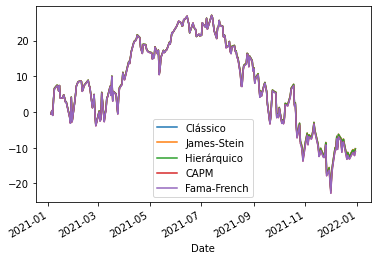

In [38]:
backtest_ret.plot()

In [39]:
backtest_ret

,Clássico,James-Stein,Hierárquico,CAPM,Fama-French
Date,,,,,
2021-01-04,-0.552044,-0.552044,-0.556359,-0.590640,-0.593825
2021-01-05,0.397308,0.397308,0.389331,0.328966,0.323473
2021-01-06,-0.810369,-0.810369,-0.827440,-0.953699,-0.965069
2021-01-07,3.710804,3.710804,3.682795,3.472087,3.452966
2021-01-08,6.640962,6.640962,6.613629,6.399781,6.380042
...,...,...,...,...,...
2021-12-23,-12.342355,-12.342355,-12.476550,-13.148277,-13.195541
2021-12-27,-10.541253,-10.541253,-10.674603,-11.338780,-11.385312
2021-12-28,-10.750651,-10.750651,-10.881224,-11.517430,-11.561136


Além da minimização da variância, outras funções objetivos podem ser utilizadas. Uma das mais famosas é o índice de Sharpe, fórmula que leva em conta a relação entre risco e retorno:

$S_i = \frac{\operatorname{E}[R_i - R_f]}{\sigma_i}$

O numerador é o retorno esperado livre de risco, ou seja, as estimativas de retorno médio que estamos usando até aqui. O denominador é a volatilidade.

In [40]:
def get_portfolio_perf(w, mu_ret, cov_matrix):
    port_ret = np.sum(mu_ret * w)
    port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    return port_ret, port_vol

def get_portfolio_sharpe(w, mu_ret, cov_matrix):
    ### o sinal de - é para que sco.minimize maximize o sharpe na função seguinte
    return -get_portfolio_perf(w, mu_ret, cov_matrix)[0]/get_portfolio_perf(w, mu_ret, cov_matrix)[1] 

def max_sharpe_port(mu_ret, cov_matrix):
    bounds = tuple((0,1) for i in range(len(mu_ret)))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    optim = sco.minimize(get_portfolio_sharpe, len(mu_ret)*[1/len(mu_ret)], args=(mu_ret, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
    return optim

In [41]:
w_cl = max_sharpe_port(ret_cl, cov_cl).x
w_js = max_sharpe_port(ret_js, cov_cl).x
w_hb = max_sharpe_port(ret_hb, cov_hb).x
w_capm = max_sharpe_port(ret_capm, cov_capm).x
w_ff = max_sharpe_port(ret_ff, cov_ff).x

weights_mat = pd.DataFrame([w_cl, w_js, w_hb, w_capm, w_ff], index=['Clássico','James-Stein','Hierárquico','CAPM','Fama-French'], columns=assets.columns)
weights_mat

,IVVB11.SA,PIBB11.SA,SMAL11.SA
Clássico,0.524015,0.144354,0.331631
James-Stein,0.543331,0.130163,0.326506
Hierárquico,0.414582,0.192690,0.392727
CAPM,0.539972,0.129741,0.330287
Fama-French,0.516401,0.141446,0.342153


<AxesSubplot:xlabel='Date'>

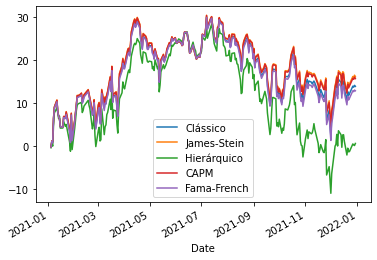

In [42]:
backtest_ret = (backtest_data @ weights_mat.T).cumsum()
backtest_ret.plot()

In [43]:
backtest_ret

,Clássico,James-Stein,Hierárquico,CAPM,Fama-French
Date,,,,,
2021-01-04,-0.191198,-0.176654,-0.386637,-0.189370,-0.226907
2021-01-05,1.166319,1.206955,0.748347,1.182968,1.100513
2021-01-06,0.934497,1.034833,-0.015108,0.983033,0.793869
2021-01-07,6.453580,6.602002,4.962297,6.517576,6.222598
2021-01-08,9.039602,9.146939,7.738846,9.065851,8.813616
...,...,...,...,...,...
2021-12-23,12.213503,14.464861,-1.278129,14.006929,11.130637
2021-12-27,13.972320,16.224657,0.503182,15.769081,12.896504
2021-12-28,13.730296,16.000208,0.275956,15.551881,12.677878
